In [1]:
#all imports here

from nilearn import plotting, image
import nibabel as nib
import os
import numpy as np
from pathlib import Path
import tarfile
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Data

In [2]:
#loading the data
sub_list = os.listdir("HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2")
make_path = lambda x: "HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2" + "/" + x

paths = [make_path(i) for i in sub_list]
sub_data = [np.loadtxt(path) for path in paths]

## Some Useful Functions

In [3]:
#lets check the 99.9 percentile
def percentile(cov_matrix, percentile=99.9):
    ''' 
    find percentile

    Takes in:
    cov_matrix
    percentile = 99.9
    '''
    cov_matrix = np.array(cov_matrix)
    iu = np.triu_indices(100, 1) #get the upper triangle and and offset it to not include the diagonal
    unique_cov = abs(cov_matrix[iu])
    threshold = np.percentile(unique_cov, percentile) #threshold for 99.9 percentile
    indices = np.where((cov_matrix >= threshold) & (cov_matrix <0.999))
    pairs = np.dstack(indices)
    unique_pairs = np.array(list({tuple(np.sort(row)) for row in pairs[0]}))
    strong_correlations = {(x, y):cov_matrix[x, y] for x, y in unique_pairs}
    return strong_correlations

In [4]:
#Setting up atlas coordinates

atlas = image.load_img("HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d100.ica/melodic_IC_sum.nii.gz")
atlas = image.threshold_img(atlas, "99.5%") 
print("atlas has shape", ["x", "y", "z", "region"], "=", atlas.shape)

atlas_coords = plotting.find_probabilistic_atlas_cut_coords(atlas)

atlas has shape ['x', 'y', 'z', 'region'] = (91, 109, 91, 100)


In [5]:
def distance_between_coords(id1, id2):
    return np.sqrt(np.sum([(atlas_coords[id2] - atlas_coords[id1])**2]))

## Correlation Matrices on Single Subject

In [15]:
#pick one random subject (index 0 - 1002)
i = 0
#get data for one subject
X = sub_data[2]
X.shape #(data points, brain regions)

(4800, 100)

In [16]:
corr_matrix = np.corrcoef(X.T)

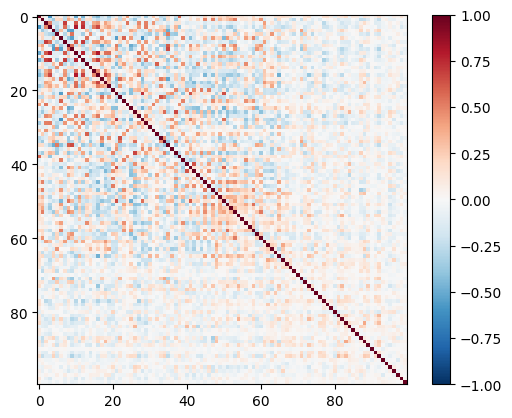

In [17]:
plt.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

## Connectivity Maps

Plotting the connectivity from the correlation matrix 

In [9]:
#lets plot it on the brain

atlas = image.load_img("HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d100.ica/melodic_IC_sum.nii.gz")
atlas = image.threshold_img(atlas, "99.5%") 
print("atlas has shape", ["x", "y", "z", "region"], "=", atlas.shape)

atlas_coords = plotting.find_probabilistic_atlas_cut_coords(atlas)

atlas has shape ['x', 'y', 'z', 'region'] = (91, 109, 91, 100)


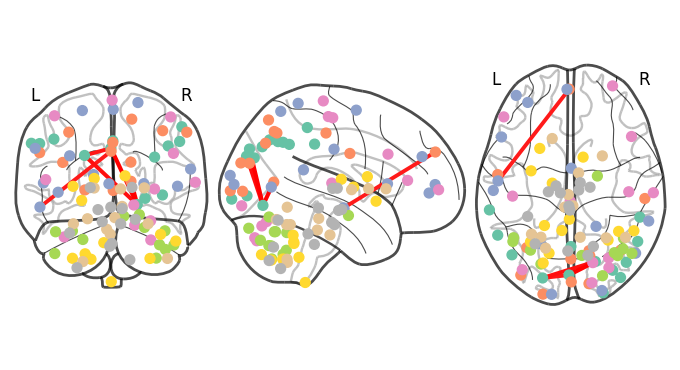

In [18]:
plotting.plot_connectome(corr_matrix, atlas_coords, edge_threshold="99.9%")

In [45]:
from nilearn import image, plotting
from atlasreader.atlasreader import read_atlas_peak

"""
available reference atlases
---------------------------
    "aal",
    "aicha",
    "desikan_killiany",
    "destrieux",
    "harvard_oxford",
    "juelich",
    "marsatlas",
    "neuromorphometrics",
    "talairach_ba",
    "talairach_gyrus",
 """

atlas = image.threshold_img("HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d100.ica/melodic_IC_sum.nii.gz", "99.5%") 
atlas_coords = plotting.find_probabilistic_atlas_cut_coords(atlas)
brain_region = []
print("BRAIN REGIONS:\n--------------")
for atlas_coord in atlas_coords:
    region = read_atlas_peak("harvard_oxford", atlas_coord)
    print(region)
    brain_region += [region]

BRAIN REGIONS:
--------------
[[np.float64(62.0), 'Right_Occipital_Pole']]
[[np.float64(50.0), 'Right_Lateral_Occipital_Cortex_superior_division'], [np.float64(30.0), 'Right_Angular_Gyrus']]
[[np.float64(56.0), 'Right_Lateral_Occipital_Cortex_inferior_division'], [np.float64(14.0), 'Right_Occipital_Pole']]
[[np.float64(54.0), 'Left_Cuneal_Cortex'], [np.float64(9.0), 'Right_Cuneal_Cortex']]
[[np.float64(81.0), 'Left_Supramarginal_Gyrus_anterior_division'], [np.float64(6.0), 'Left_Supramarginal_Gyrus_posterior_division']]
[[np.float64(85.0), 'Right_Lateral_Occipital_Cortex_superior_division']]
[[np.float64(66.0), 'Right_Supramarginal_Gyrus_posterior_division'], [np.float64(14.0), 'Right_Angular_Gyrus']]
[[np.float64(68.0), 'Right_Lateral_Occipital_Cortex_superior_division']]
[[np.float64(72.0), 'Left_Lateral_Occipital_Cortex_superior_division']]
[[np.float64(49.0), 'Right_Precuneous_Cortex'], [np.float64(30.0), 'Left_Precuneous_Cortex']]
[[np.float64(47.0), 'Right_Occipital_Fusiform_Gyru

In [63]:
#select the correct region with largest probability given from the library
brain_region = [
    max(inner_list, key=lambda x: x[0])[-1] if inner_list else None for inner_list in brain_region
]
brain_region

['Right_Occipital_Pole',
 'Right_Lateral_Occipital_Cortex_superior_division',
 'Right_Lateral_Occipital_Cortex_inferior_division',
 'Left_Cuneal_Cortex',
 'Left_Supramarginal_Gyrus_anterior_division',
 'Right_Lateral_Occipital_Cortex_superior_division',
 'Right_Supramarginal_Gyrus_posterior_division',
 'Right_Lateral_Occipital_Cortex_superior_division',
 'Left_Lateral_Occipital_Cortex_superior_division',
 'Right_Precuneous_Cortex',
 'Right_Occipital_Fusiform_Gyrus',
 'Left_Angular_Gyrus',
 'Left_Lateral_Occipital_Cortex_superior_division',
 'Left_Lateral_Occipital_Cortex_superior_division',
 'Left_Precuneous_Cortex',
 'Right_Occipital_Pole',
 'Right_Intracalcarine_Cortex',
 'Right_Lateral_Occipital_Cortex_superior_division',
 'Left_Occipital_Pole',
 'Left_Lateral_Occipital_Cortex_superior_division',
 'Left_Postcentral_Gyrus',
 'Left_Superior_Frontal_Gyrus',
 'Right_Supramarginal_Gyrus_anterior_division',
 'Right_Lateral_Occipital_Cortex_superior_division',
 'Left_Occipital_Pole',
 'Lef

## Correlation Statistics

Getting the average squared correlation values

$$
c = \frac{1}{n}\sum_{i}\sum_{j}(x_{ij})^2
$$

In [6]:
#getting the average squared correlation values
sqr_corr = lambda corr_matrix: np.sum(corr_matrix.flatten()**2) / len(corr_matrix) **2

In [ ]:
sqr_corr(corr_matrix)

np.float64(0.03773806218360494)

In [8]:
np.random.seed(0)
range = np.random.random_integers(0, 1002, 1002)
data = []
stats = []
for i in range:
    data.append(np.corrcoef(sub_data[i].T))
    stats.append(sqr_corr(data[-1]))


/var/folders/p1/nnm56jzx5f36hgsqbgpnkr880000gn/T/ipykernel_5222/2365991267.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 1002 + 1) instead
  range = np.random.random_integers(0, 1002, 1002)


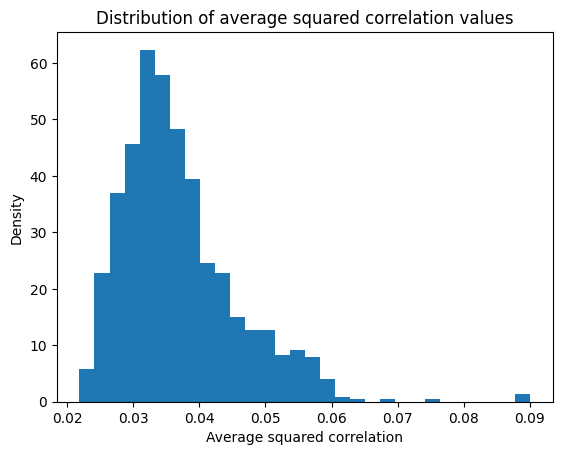

In [9]:
sqr_corr_plt = plt.hist(stats, bins=30, density=True)
plt.title("Distribution of average squared correlation values")
plt.xlabel("Average squared correlation")
plt.ylabel("Density")
plt.show()

In [10]:
std_corr = lambda corr_matrix: corr_matrix.flatten().std()

In [11]:
std_corr(corr_matrix)

NameError: name 'corr_matrix' is not defined

In [12]:
stats2= []
for i in data:
    stats2.append(std_corr(i))

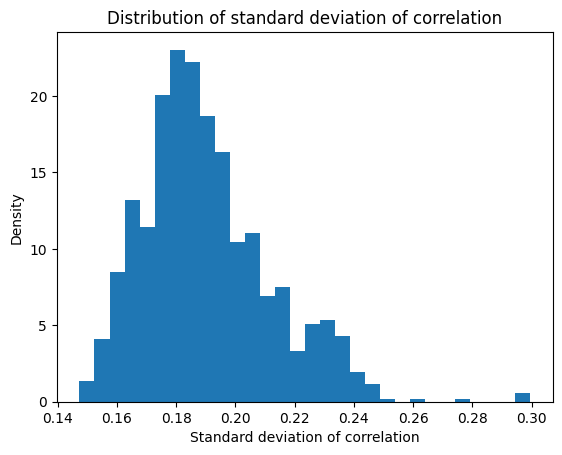

In [13]:
std_corr_plt = plt.hist(stats2, bins=30, density=True)
plt.title("Distribution of standard deviation of correlation")
plt.xlabel("Standard deviation of correlation")
plt.ylabel("Density")
plt.show()

## Top Correlations Across All Subjects

In [14]:
# finding 99.9 percentile of edges

edges = []
for i in range:
    edges.append(percentile(data[i]))

In [56]:
unique_edges = pd.DataFrame(edges).nunique(axis=0)

In [57]:
unique_edges = pd.DataFrame(edges).nunique(axis=0)
unique_edges = unique_edges.to_frame().reset_index()
unique_edges.columns = ['edge', 'unique_edges']
unique_edges['edge_tup'] = unique_edges['edge'].apply(lambda x: tuple(x))
unique_edges['edge'] = unique_edges['edge'].apply(lambda x: f'({x[0]},{x[1]})')
unique_edges = unique_edges.sort_values('unique_edges', ascending=False)

In [58]:
unique_edges['dist'] = unique_edges['edge_tup'].apply(lambda x: distance_between_coords(x[0], x[1]))

In [59]:
# unique_edges['brain_region1'] = unique_edges['edge_tup'].apply(lambda x: brain_region[x[0]])
# unique_edges['brain_region2'] = unique_edges['edge_tup'].apply(lambda x: brain_region[x[1]])

In [60]:
unique_edges.head(10)

,edge,unique_edges,edge_tup,dist
5,"(3,10)",221,"(3, 10)",48.204446
1,"(10,16)",188,"(10, 16)",20.016864
10,"(26,37)",142,"(26, 37)",48.130472
27,"(3,16)",129,"(3, 16)",34.583980
23,"(10,12)",124,"(10, 12)",55.977511
13,"(2,7)",123,"(2, 7)",29.797999
2,"(24,38)",100,"(24, 38)",39.729832
7,"(0,24)",93,"(0, 24)",46.091622
3,"(7,12)",91,"(7, 12)",53.411894
4,"(16,18)",77,"(16, 18)",28.047823


In [61]:
df = unique_edges[['edge', 'unique_edges']]
np.percentile(df['unique_edges'], 75)
df = df[df['unique_edges'] > np.percentile(df['unique_edges'], 50)]
unique_edges_plt = alt.Chart(df).mark_bar().encode(
    x=alt.X('unique_edges:Q').title('Number of unique edges'),
    y=alt.Y('edge:N', sort='-x').title('Edge'),
    tooltip='unique_edges'
).properties(
    title='Top high correlation edges in correlation matrices of 1002 subjects'
)
unique_edges_plt

alt.Chart(...)

## Principal Components of Correlation Matrices Across Subjects

In [39]:
corr_matrix = np.sum(data, axis=0) / len(data)

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

# Sort the eigenvalues in descending order and get the indices
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]

# Sort the eigenvectors according to the sorted indices
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Get the top k eigenvectors (e.g., top 2)
k = 10
top_eigenvectors = sorted_eigenvectors[:, :k]

# print("Eigenvalues:", len(eigenvalues))
# print("Sorted Eigenvalues:", eigenvalues[sorted_indices])
# print("Top Eigenvectors:\n", top_eigenvectors)

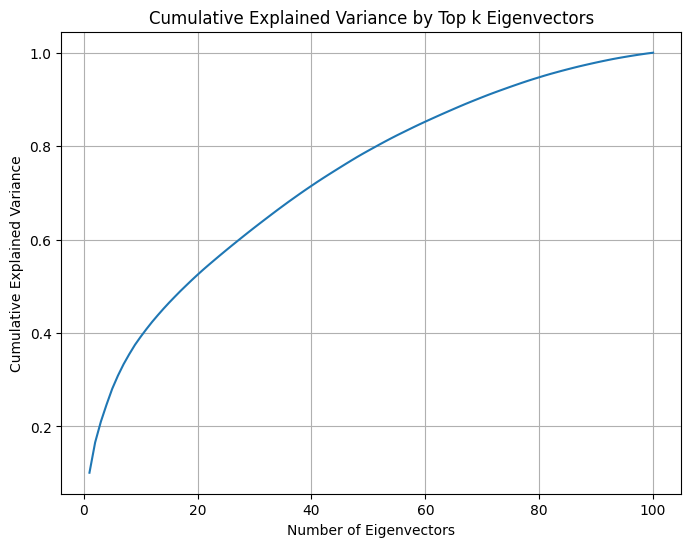

In [40]:
# Compute the explained variance for each eigenvalue
explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)

# Compute the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
k =100  # Number of top eigenvectors to consider
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, k+1), cumulative_explained_variance[:k])
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Top k Eigenvectors')
plt.grid(True)
plt.show()

In [88]:
df = pd.DataFrame(sorted_eigenvectors, index= brain_region, columns=np.arange(1, 101))
df = df.apply(lambda x: np.round(x, 2))
distribution_vecs = (df > 0).sum()
distribution_reg = (df > 0).sum(axis=1)

Text(0, 0.5, 'Number of contributing brain regions')

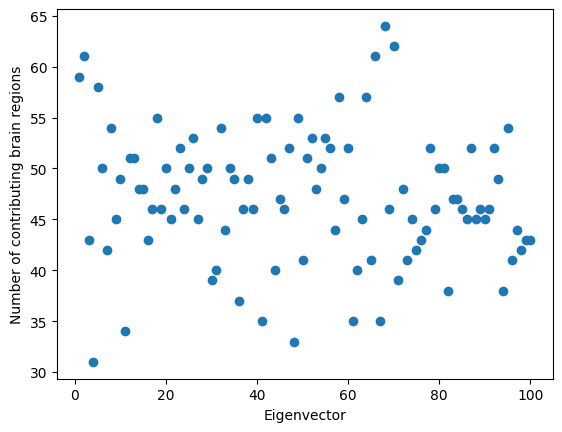

In [90]:
plt.scatter(np.arange(1, 101), distribution_vecs)
plt.xlabel('Eigenvector')
plt.ylabel('Number of contributing brain regions')

Text(0, 0.5, 'Number of eigenvectors it contributes to')

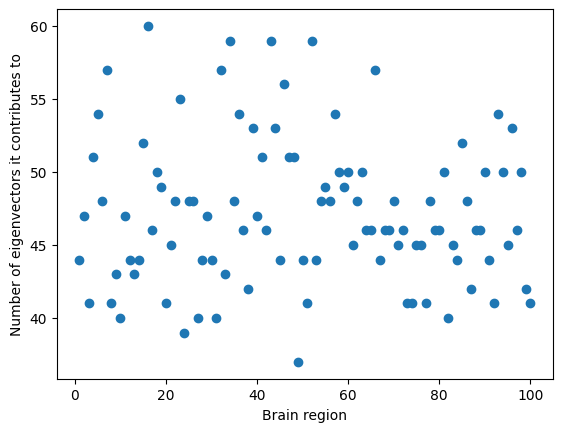

In [92]:
plt.scatter(np.arange(1, 101), distribution_reg)
plt.xlabel('Brain region')
plt.ylabel('Number of eigenvectors it contributes to')

In [42]:
sorted_eigenvalues

array([10.08799278,  6.49880488,  4.41966684,  3.66069397,  3.39960789,
        2.80054512,  2.46660813,  2.15084584,  1.99711981,  1.72572174,
        1.61957849,  1.54305548,  1.43439237,  1.38348133,  1.3199207 ,
        1.26343323,  1.2378586 ,  1.17859962,  1.17050624,  1.12713361,
        1.09858304,  1.05383037,  1.03510591,  1.027475  ,  1.00987573,
        1.00001372,  0.98446669,  0.97921864,  0.96883203,  0.95489043,
        0.94202325,  0.93082039,  0.92837838,  0.92123937,  0.89843443,
        0.89417871,  0.86643133,  0.8637267 ,  0.84473112,  0.82464403,
        0.81986139,  0.7938708 ,  0.77820343,  0.76561164,  0.7610388 ,
        0.75663366,  0.7435955 ,  0.73460442,  0.70267374,  0.68181061,
        0.67222083,  0.66520941,  0.65722207,  0.64165078,  0.62204701,
        0.60247667,  0.5984162 ,  0.59441364,  0.58158719,  0.56519497,
        0.55594035,  0.5497774 ,  0.54568726,  0.53401094,  0.5311834 ,
        0.5264072 ,  0.51610014,  0.49905514,  0.48971734,  0.48

#### Some Interpretation
1. What the eigenvectors capture
The eigenvectors of a correlation matrix define directions in the data space (here, the space of brain regions) along which the variation (or "correlation structure") is most strongly organized.
Each eigenvector is a vector of length 100 (in your example, corresponding to your 100 brain regions). The entries of an eigenvector indicate the relative contribution of each brain region to that specific pattern of variation.
2. How the eigenvalues fit in
The eigenvalues associated with these eigenvectors tell you how much of the total correlation structure is explained by each eigenvector. A higher eigenvalue means that the corresponding eigenvector accounts for a larger portion of the correlated variation in the brain regions.
3. Physical/biological interpretation
If the correlation matrix represents the functional connectivity of brain regions, the eigenvectors may represent functional modes or networks. For example:
The first eigenvector (associated with the largest eigenvalue) typically represents the global mode of correlation, capturing the pattern where most regions correlate together.
Subsequent eigenvectors describe more specific, localized patterns of correlated activity. For instance, one eigenvector might highlight a pattern where a specific subset of brain regions is strongly intercorrelated.
Each eigenvector can be thought of as a spatial pattern of brain region activity.
4. Orthogonality of eigenvectors
The eigenvectors are orthogonal to one another (in the mathematical sense). This means that each eigenvector describes a unique, uncorrelated mode of variation, making them ideal for identifying independent patterns in the data.
5. Applications
Network Analysis: You could use the eigenvectors to identify clusters of regions that exhibit coherent activity patterns.
Dimensionality Reduction: If many of the eigenvalues are small, you might approximate the correlation matrix using only the eigenvectors with large eigenvalues, reducing the complexity of your data while retaining most of the meaningful structure.
Interpretation of Specific Eigenvectors: Examining the brain regions with the highest weights in each eigenvector might reveal functional networks (e.g., motor regions, visual areas, etc.).

## Sliding Time Windows on Single Subject

In [ ]:
def sliding_windows(data, num_windows, create_figure=False):
    len_window = 4800//num_windows
    window_matrices = []
    if create_figure:
        fig, axs = plt.subplots(num_windows//4, 4, figsize=(15, 10))
    for i in range(num_windows):
        row = i//4
        col = i % 4
        i = int(i*len_window//2)
        lil_data = data[i: i + len_window]
        sub_corr_matrix = np.corrcoef(lil_data.T)
        window_matrices.append(sub_corr_matrix) 
        if create_figure:
            img = axs[row][col].imshow(sub_corr_matrix, cmap="RdBu_r",vmin=-1, vmax=1, interpolation="none")
        # axs[row][col].title(f"corr graph in window {i} to {i+len_5_min}")
        #plt.show()
    if create_figure:
        fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, shrink = 0.4)
    return window_matrices

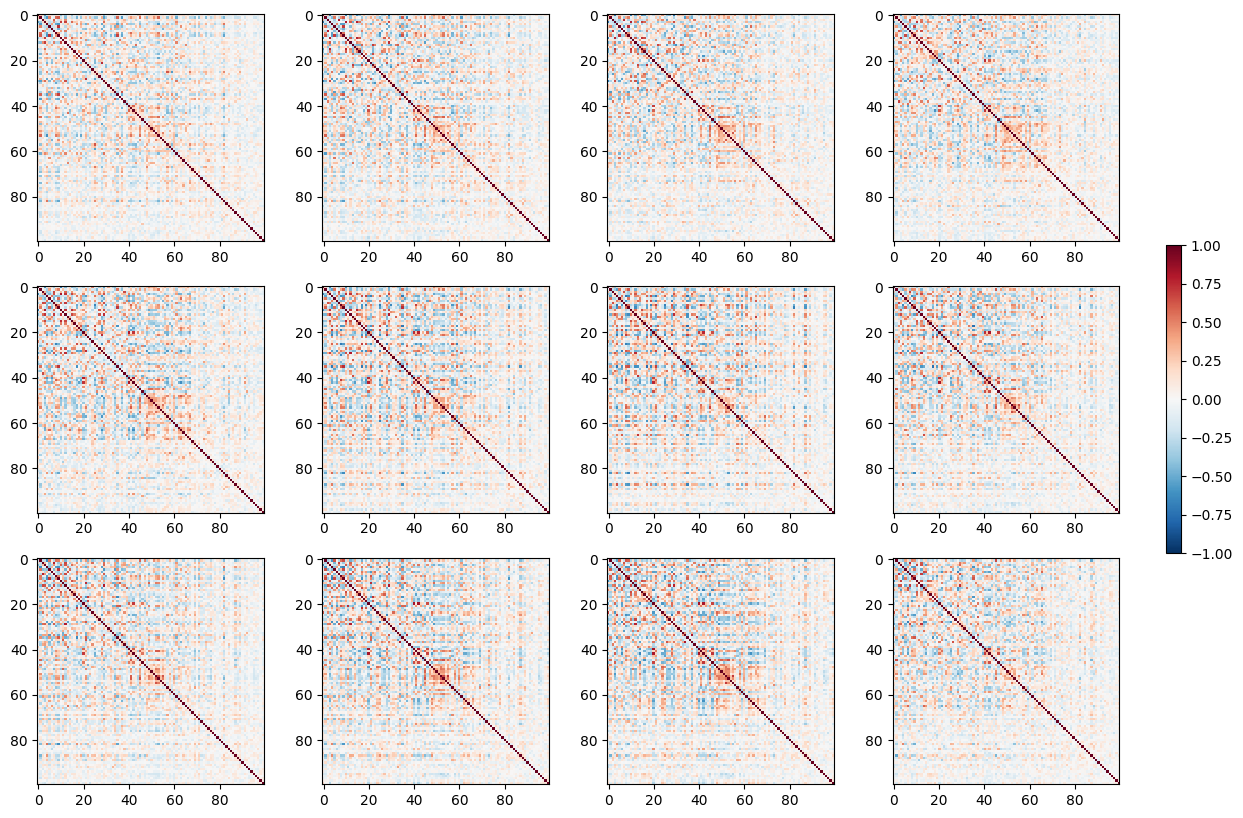

In [ ]:
num_windows = 12
data = X
windows12 = sliding_windows(data, num_windows, True)

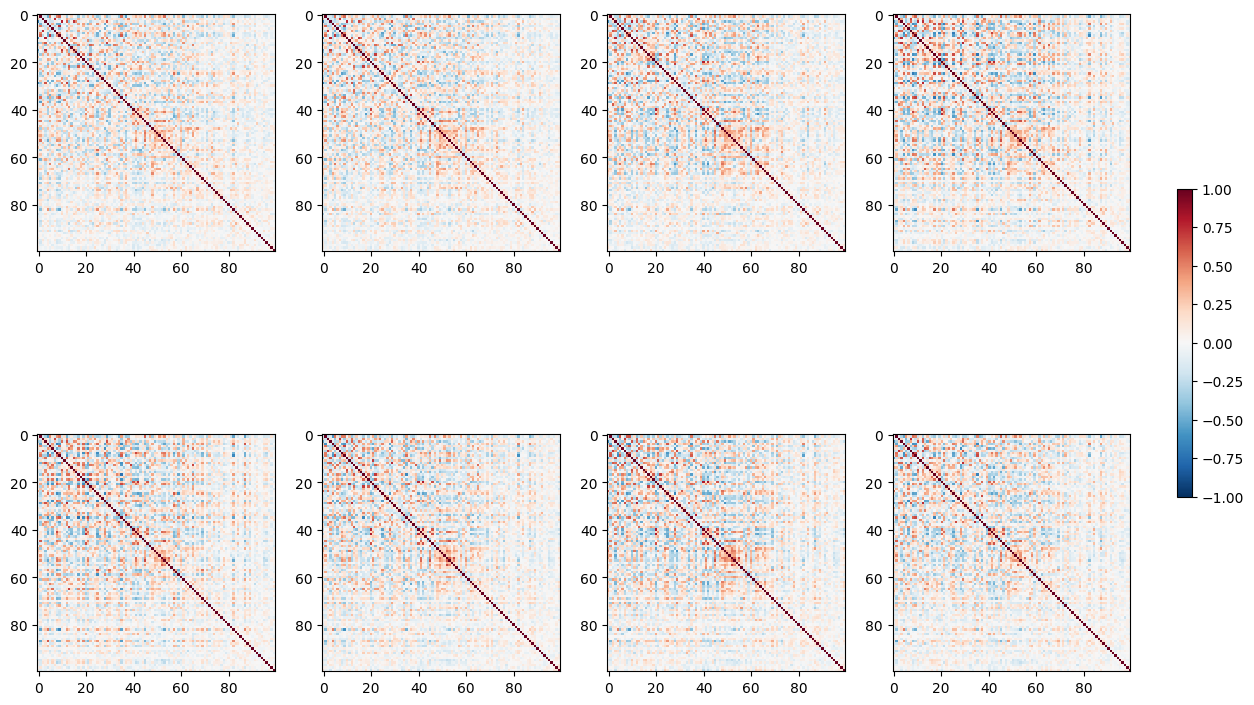

In [ ]:
num_windows = 8
data = X
windows8 = sliding_windows(data, num_windows, True)

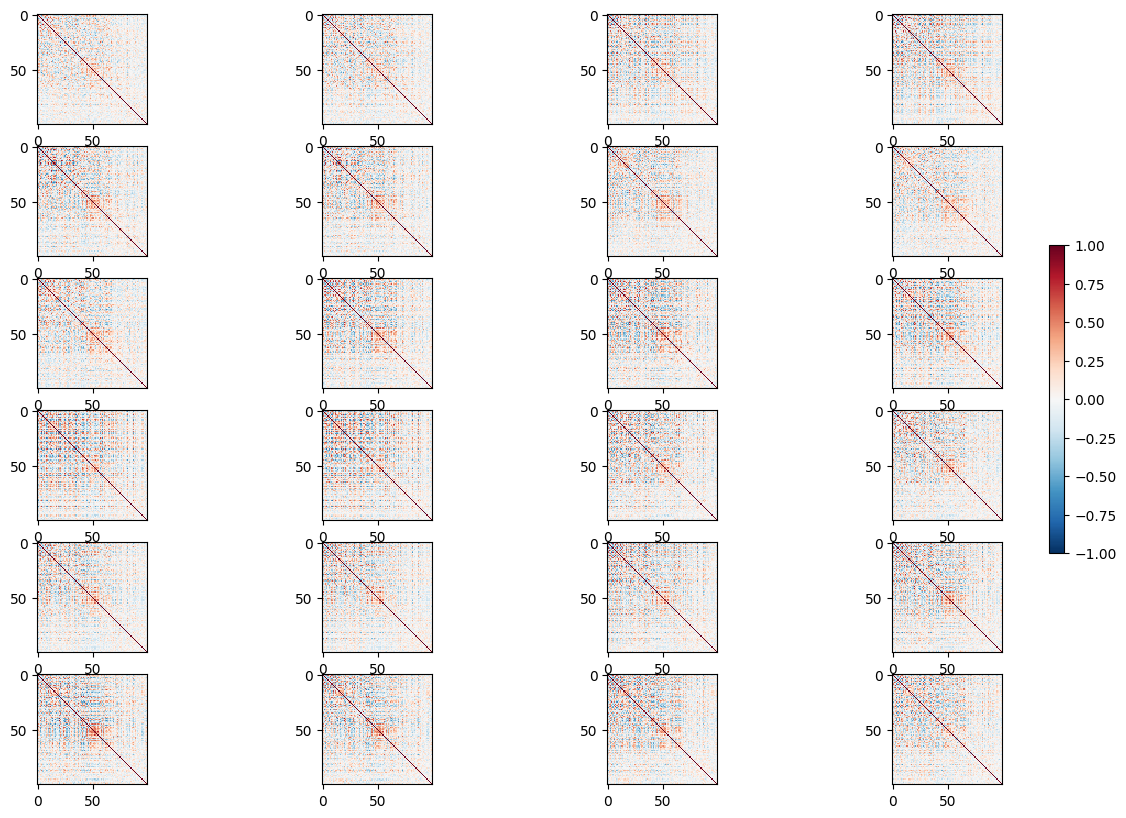

In [ ]:
num_windows = 24
data = X
windows24 = sliding_windows(data, num_windows, True)

## Correlation Plots across Time Windows

In [12]:
def get_data_over_time(matrices, x, y):
    data = np.array(matrices)[:, x, y]
    data = pd.DataFrame({
        'x': range(1, len(data) + 1),  # Generate x-axis values (e.g., 1, 2, 3, ...)
        'y': data,
        'group':[f'({x},{y})']*len(data) # Use the list for y-axis values
    })
    return data
    
def plot_correlations_over_time(data, title):
    chart = alt.Chart(data).mark_line().encode(
    x=alt.X('x', title='Time Window'),
    y=alt.Y('y', title = 'Correlation'),
    color='group',
    tooltip=['group'],
    ).properties(title=f'{title}', )
    return chart

In [14]:
charts = {}
plot_data = {}
for mat in windows12:
    top_correlations = percentile(mat).keys()
    for x,y in top_correlations: 
        data = get_data_over_time(windows12, x, y)
        chart = plot_correlations_over_time(data, '99.9 percentile corrlations over 12 time windows')
        charts[(x, y)] = chart
        # distance = distance_between_coords(x, y)
        # plot_data[(x, y)] = [data, distance]

In [15]:
combined_chart = alt.layer(*charts.values()).interactive()
combined_chart


alt.LayerChart(...)

This chart shows the 99.9th percentile correlations, meaning the highest correlations across the 12 time windows and how they vary.

In [ ]:
data = pd.DataFrame({'x':[], 'y':[], 'group': []})
indices = list(zip(*np.triu_indices(100, 1)))
for mat in windows12:
    top_correlations = percentile(mat).keys()
    for x,y in top_correlations: 
        data = pd.concat((data, get_data_over_time(windows12, x, y)), axis=0)


In [77]:
alt.Chart(data, width=100).transform_density(
    'y',
    as_=['y', 'density'],
    extent=[0, 1],
    groupby=['x']
).mark_area(orient='horizontal').encode(
    alt.X('density:Q')
        .stack('center')
        .impute(None)
        .title(None)
        .axis(labels=False, values=[0], grid=False, ticks=True),
    alt.Y('y:Q'),
    alt.Color('x:N'),
    alt.Column('x:N')
        .spacing(0)
        .header(titleOrient='bottom', labelOrient='bottom', labelPadding=0)
).configure_view(
    stroke=None
)

alt.Chart(...)

This chart describes the distribution of top_correlations across 12 time windows.

Some lines vary a lot while others vary less over time. I decided to plot the distribution of the standard deviation of all pair of points.

In [93]:
indices = list(zip(*np.triu_indices(100, 1)))
point_dct = {}
for x,y in indices: 
    data = np.array(windows12)[:, x, y]
    point_dct[(x, y)] = np.std(data)

In [100]:
df = pd.DataFrame({'std': list(point_dct.values())}, index = range(len(point_dct.keys())))

In [103]:
#This is a distribution of standard deviations of correlation across 12 windows across pairs
alt.Chart(df).mark_bar().encode(
    alt.X('std:Q', bin=True),
    alt.Y('count()')
).properties(title='distribution of standard deviation over of all correlations')

alt.Chart(...)

In [118]:
point_dct = {key: plot_data[key][0].y.std() for key in plot_data.keys()}

In [119]:
df = pd.DataFrame({'std': list(point_dct.values())}, index = range(len(point_dct.keys())))

In [120]:
#This is a distribution of standard deviations of correlation across 12 windows across pairs
alt.Chart(df).mark_bar().encode(
    alt.X('std:Q', bin=True),
    alt.Y('count()')
).properties(title='distribution of standard deviation over of all correlations')

alt.Chart(...)

## Distribution of Correlation by Distance in the Brain

In [16]:
def distance_between_coords(id1, id2):
    return np.sqrt(np.sum([(atlas_coords[id2][i] - atlas_coords[id1][i])**2 
                           for i in range(3)]))

In [17]:
#distirbution of distances
dist = []
indices = np.triu_indices(100, 1)
for i, j in zip(*indices):
    dist.append(distance_between_coords(i, j))
df = pd.DataFrame({'dist':dist})
df.shape

(4950, 1)

In [18]:
#This is a distribution of all distance pairs excluding the diagonal
alt.Chart(df).mark_bar().encode(
    alt.X('dist:Q', bin=True),
    alt.Y('count()')
).properties(title='distribution of dist between 100 regions')

alt.Chart(...)

In [19]:
distances = []
df = pd.DataFrame({'x':[], 'y': [], 'cor':[], 'dist':[]})
for mat in windows12:
    top_correlations = percentile(mat, 99.9)
    top_correlations_id = top_correlations.keys()
    indices = np.triu_indices(100, 1)
    for x,y in zip(*indices):
        distance = distance_between_coords(x, y)
        distances.append(distance)
        df.loc[len(df)] = [x, y, mat[x][y], distance]

Text(0.5, 1.0, 'Distance vs. Correlation Plot')

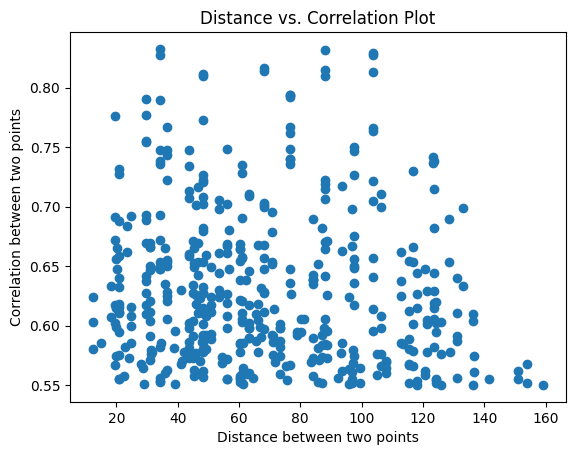

In [27]:
threshold = 0.55
sample = df[df['cor'] > threshold]
plt.scatter(x=sample['dist'], y=sample['cor'])
plt.xlabel('Distance between two points')
plt.ylabel('Correlation between two points')
plt.title("Distance vs. Correlation Plot")

In [21]:
#-1 is the left hemisphere, 1 is the right hemisphere, 0 is the middle
assign_hemisphere = lambda x: -1 if x[0] < 0 else 1 if x[0] > 0 else 0

In [22]:
#adding columns for x and y hemisphere
def add_hemisphere(df):
    df['x_hemisphere'] = df['x'].apply(lambda x: 1 if atlas_coords[int(x)][0] > 0 else -1 if atlas_coords[int(x)][0] < 0 else 0)
    df['y_hemisphere'] = df['y'].apply(lambda x: 1 if atlas_coords[int(x)][0] > 0 else -1 if atlas_coords[int(x)][0] < 0 else 0)
    #same or different hemisphere
    df['same_hemisphere'] = df['x_hemisphere'] == df['y_hemisphere']
    return df

In [23]:
def data_df(corr_mats, indices, top_correlations=False):
    distances = []
    # df = pd.DataFrame({'x':[], 'y': [], 'cor':[], 'dist':[]})
    rows = []
    for mat in corr_mats:
        if top_correlations:
            top_correlations = percentile(mat, 99.9)
            top_correlations_id = top_correlations.keys()
            indices = top_correlations_id
        for x,y in indices:
            distance = distance_between_coords(x, y)
            distances.append(distance)
            rows.append({'x': x, 'y': y, 'cor': mat[x][y], 'dist': distance})
    df = pd.DataFrame(rows)
    return df
df = data_df(windows12, list(zip(*indices)))
df.shape
df_top = data_df(windows12, None, True)

In [24]:
df = add_hemisphere(df)
df_top = add_hemisphere(df_top)

In [ ]:
def plot_correlation_vs_distance(df, threshold=-1):
    sample = df[df['cor'] > threshold]
    plt.scatter(x=sample['dist'], y=sample['cor'], c=sample['same_hemisphere'], cmap='coolwarm')
    plt.title('Correlation vs Distance')
    plt.xlabel('Distance between two points (mm)')
    plt.ylabel('Correlation between two points')

    legend_labels = ['Different Hemisphere', 'Same Hemisphere']
    coolwarm = plt.colormaps['coolwarm']
    colors =  [coolwarm(0), coolwarm(300)]
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    legend = plt.legend(handles, legend_labels, title='Hemisphere', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

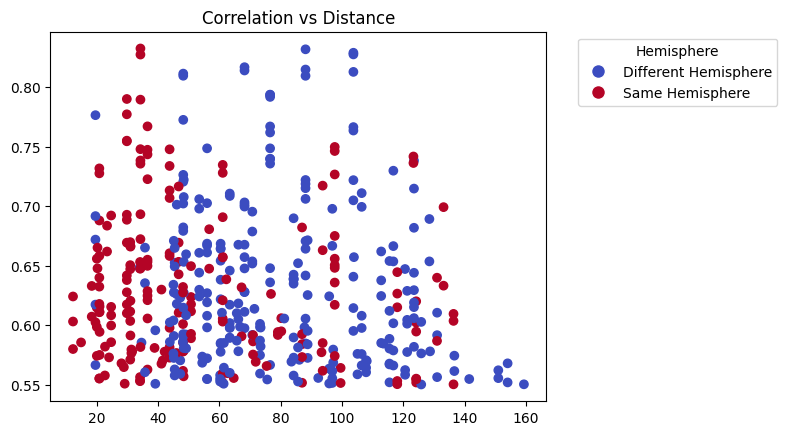

In [26]:
plot_correlation_vs_distance(df, 0.55)

Subject Index: 0


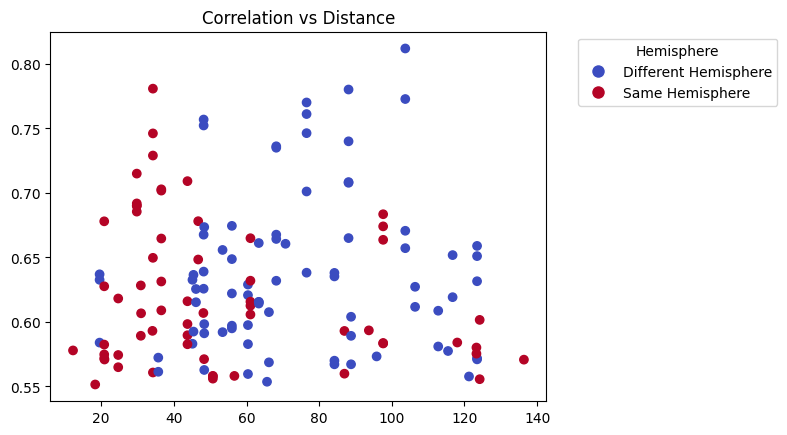

Subject Index: 4


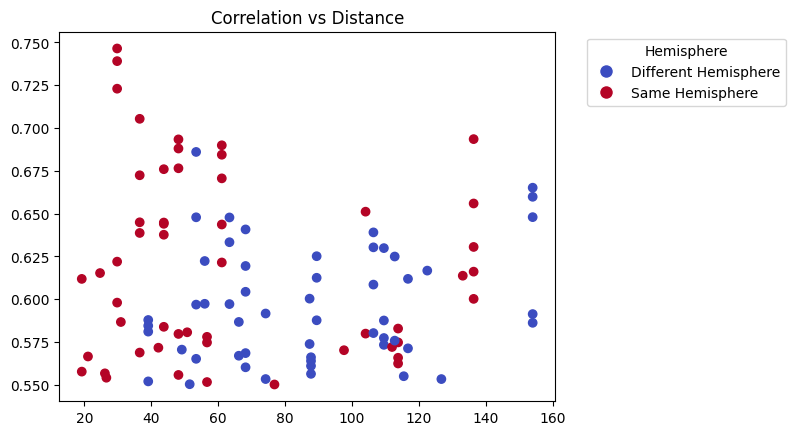

Subject Index: 8


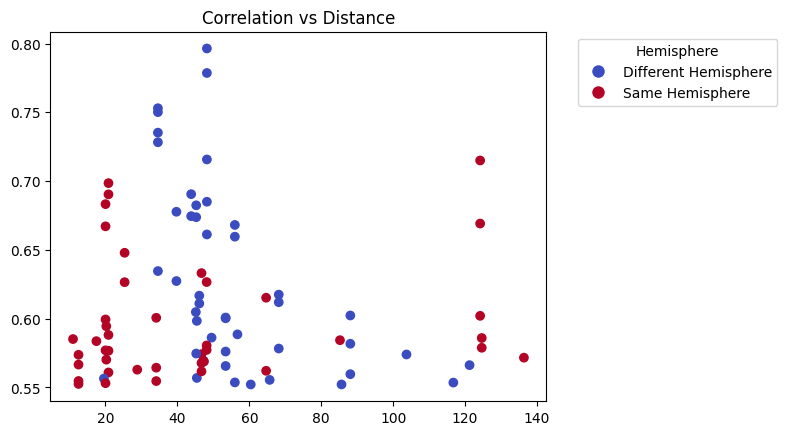

Subject Index: 12


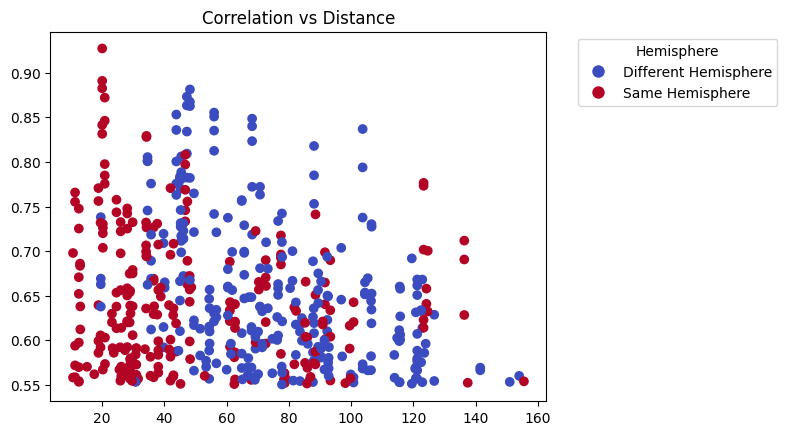

Subject Index: 16


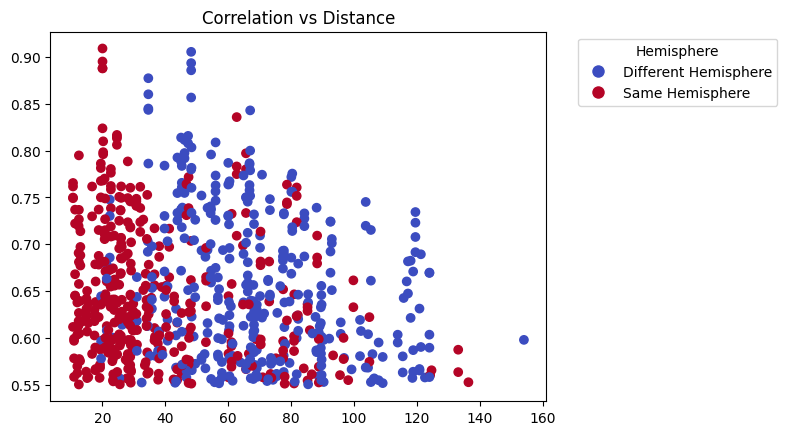

Subject Index: 20


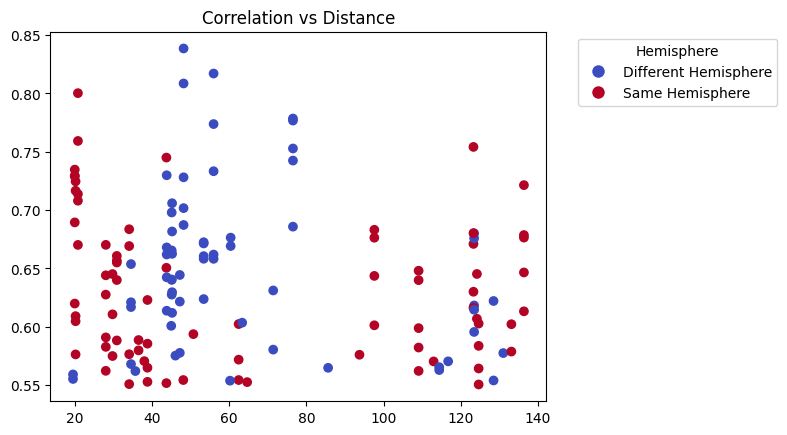

In [31]:
for i in range(0, 24, 4):
    windows5 = sliding_windows(sub_data[i], 5)
    data5 = data_df(windows5, list(zip(*indices)))
    data = add_hemisphere(data5)
    print(f'Subject Index: {i}')
    plot_correlation_vs_distance(data, 0.55)